In [1]:
# https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/blob/master/Chapter%208/Curiosity-Driven%20Exploration%20Super%20Mario.ipynbs
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import resize
import numpy as np
from random import shuffle
from collections import deque
from IPython import display
import time
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [3]:
# let's explore the environment
done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
time.sleep(2)
env.close()

Text(0.5, 0.98, 'Transformed Input Image')

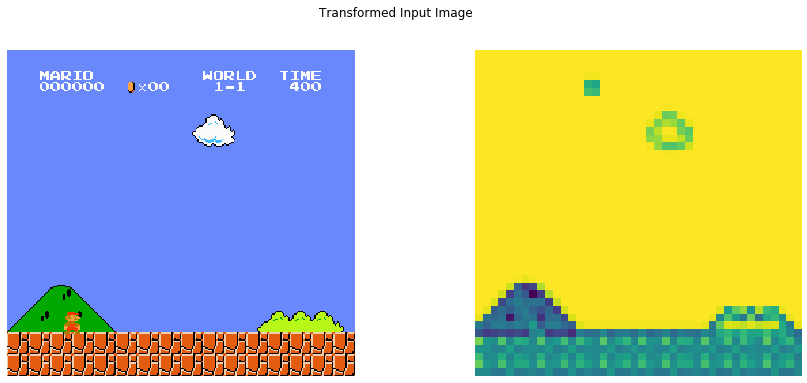

In [4]:
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    """This function process input image so it has smaller size 
    and onnly one color channel """
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)
    else:
        return resize(obs, new_size, anti_aliasing=True)

# plot transformed input image
plt.figure(figsize=(15, 6))
plt.subplot(121)
img = env.reset()
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
gray_img = downscale_obs(img)
plt.imshow(gray_img)
plt.axis('off')
plt.suptitle('Transformed Input Image')

In [5]:
# let's define the Q-Network 
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,12)
        
    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y) 
        return y



In [6]:
# let's define the encoder


class Phi(nn.Module): 
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) 
        y = y.flatten(start_dim=1) 
        return y



In [7]:
# let's define the inverse model
class Gnet(nn.Module): 
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576,256)
        self.linear2 = nn.Linear(256,12)

    def forward(self, state1,state2):
        x = torch.cat( (state1, state2) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y,dim=1)
        return y

In [8]:
# let's define the forward model
class Fnet(nn.Module):
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300,256)
        self.linear2 = nn.Linear(256,288)

    def forward(self,state,action):
        action_ = torch.zeros(action.shape[0],12)
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat( (state,action_) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

In [9]:
# now the policy 
def policy(qvalues, eps=None): 
    """ Epsilon Greedy"""
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0,high=7,size=(1,))
        else:
            return torch.argmax(qvalues)
    else:
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)

In [10]:
# experience replay
class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N 
        self.batch_size = batch_size
        self.memory = [] 
        self.counter = 0
        
    def add_memory(self, state1, action, reward, state2):
        self.counter +=1 
        if self.counter % 500 == 0:
            self.shuffle_memory()
            
        if len(self.memory) < self.N:
            self.memory.append( (state1, action, reward, state2) )
        else:
            rand_index = np.random.randint(0,self.N-1)
            self.memory[rand_index] = (state1, action, reward, state2) 

    def shuffle_memory(self):
        shuffle(self.memory)
        
    def get_batch(self):
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None

        ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False)
        batch = [self.memory[i] for i in ind] #batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

In [11]:
# some parameters
params = {
    'batch_size':150,
    'beta':0.2,
    'lambda':0.1,
    'eta': 1.0,
    'gamma':0.2,
    'max_episode_len':100,
    'min_progress':15,
    'action_repeats':6,
    'frames_per_state':3
}

In [12]:
from torch import optim

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) 
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

In [13]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4): #action is an integer [0:11]
    """ Intrinsic Curiosity Module (ICM): Calculates prediction error for forward and inverse dynamics """
    state1_hat = encoder(state1)
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach())
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, \
                        state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat) 
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, \
                                        action.detach().flatten()).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

In [14]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    """
    Overall loss function to optimize for all 4 modules
    Loss function based on calculation in paper
    """
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    return loss

In [15]:
def prepare_state(state):
    """
    First downscale state, convert to grayscale, convert to torch tensor and add batch dimension
    """
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def prepare_multi_state(state1, state2):
    """
    Prepare a 3 channel state (for use in inference not training).
    
    The Q-model and encoder/Phi model expect the input state to have 3 channels. Following the reference paper,
    these models are fed 3 consecutive state frames to give the model's access to motion information 
    (i.e. velocity information rather than just positional information)
    """
    #prev is 1x3x42x42
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    #shift data along tensor to accomodate newest observation (we could have used deque w/ maxlen 3)
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp #replace last frame
    return state1

def prepare_initial_state(state,N=3):
    """
    Prepares the initial state which is just a tensor of 1 (Batch) x 3 x 42 x 42
    
    The channel dimension is just a copy of the input state 3 times
    
    """
    #state should be 42x42 array
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N,1,1)) #now 3x42x42
    return tmp.unsqueeze(dim=0) #now 1x3x42x42

In [16]:
def reset_env():
    """
    Reset the environment and return a new initial state
    """
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
    return state1

In [17]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch() 
    action_batch = action_batch.view(action_batch.shape[0],1)
    reward_batch = reward_batch.view(reward_batch.shape[0],1)
    #replay.get_batch returns tuple (state1, action, reward, state2) where each tensor has batch dimension
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #internal curiosity module
    i_reward = (1. / params['eta']) * forward_pred_err
    reward = i_reward.detach()
    if use_extrinsic:
        reward += reward_batch 
    qvals = Qmodel(state2_batch)
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack( (torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

In [ ]:
epochs = 2500
env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))
eps=0.15
losses = []
ep_lengths = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
last_x_pos = env.env.env._x_position
for i in range(epochs):
    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1)
    if i > switch_to_eps_greedy:
        action = int(policy(q_val_pred,eps))
    else:
        action = int(policy(q_val_pred))
    for j in range(params['action_repeats']):
        state2, e_reward_, done, info = env.step(action)
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque),dim=1)
    replay.add_memory(state1, action, e_reward, state2)
    e_reward = 0
    if i % params['max_episode_len'] == 0 and i != 0:
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
    if done:
        print("Episode over.")
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = env.env.env._x_position
        episode_length = 0
    else:
        state1 = state2
    #Enter mini-batch training
    if len(replay.memory) < params['batch_size']:
        continue
    
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=False)
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err)
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(), inverse_pred_err.flatten().mean(), episode_length)
    if i % 250 == 0:
        print("Epoch {}, Loss: {}".format(i,loss))
        print("Forward loss: {} \n Inverse loss: {} \n Qloss: {}".format(\
                             forward_pred_err.mean(),inverse_pred_err.mean(),q_loss.mean()))
        print(info)
    losses.append(loss_list)
    loss.backward()
    opt.step()

/home/arturo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
/home/arturo/anaconda3/lib/python3.7/site-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Epoch 250, Loss: 4900.20947265625
Forward loss: 1.5566306114196777 
 Inverse loss: 24483.7734375 
 Qloss: 22.084510803222656
{'coins': 2, 'flag_get': False, 'life': 1, 'score': 700, 'stage': 1, 'status': 'small', 'time': 391, 'world': 1, 'x_pos': 8, 'x_pos_screen': 8, 'y_pos': 117}
Episode over.
Episode over.
Epoch 500, Loss: 5010.20703125
Forward loss: 0.06665535271167755 
 Inverse loss: 24879.328125 
 Qloss: 342.8762512207031
{'coins': 0, 'flag_get': False, 'life': 1, 'score': 0, 'stage': 1, 'status': 'small', 'time': 383, 'world': 1, 'x_pos': 13, 'x_pos_screen': 13, 'y_pos': 122}
Episode over.
Episode over.
Epoch 750, Loss: 4990.48193359375
Forward loss: 0.09179939329624176 
 Inverse loss: 24792.94921875 
 Qloss: 318.19342041015625
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 385, 'world': 1, 'x_pos': 43, 'x_pos_screen': 43, 'y_pos': 93}
Epoch 1000, Loss: 5005.41650390625
Forward loss: 0.031126737594604492 
 Inverse loss: 24842.095703

In [ ]:
losses_ = np.array(losses)
ep_lengths_ = np.array(ep_lengths)
plt.figure(figsize=(8,6))
plt.plot(np.log(losses_[:,0]),label='Q loss')
plt.plot(np.log(losses_[:,1]),label='Forward loss')
plt.plot(np.log(losses_[:,2]),label='Inverse loss')
#plt.plot(ep_lengths_, label='Episode Length')
plt.legend()
plt.show()

In [ ]:
# Test model
eps=0.15
done = True
state_deque = deque(maxlen=params['frames_per_state'])
for step in range(5000):
    if done:
        env.reset()
        state1 = prepare_initial_state(env.render('rgb_array'))
    q_val_pred = Qmodel(state1)
    action = int(policy(q_val_pred,eps))
    state2, reward, done, info = env.step(action)
    state2 = prepare_multi_state(state1,state2)
    state1=state2
    env.render()
#env.close()

In [ ]:
def softmax(q,tau=1.4): #q is vector
    q = F.normalize(q)
    return torch.exp(q/tau) / torch.sum(torch.exp(q/tau))

In [ ]:
def test_encoder(from_replay=False):
    """
    Test's the encoder's ability to disentangle similar states.
    
    If the encoder is being properly trained, it should learn to encode similar states such that their 
    euclidian distance is relatively large, so that the the forward network and inverse network can make
    better predictions. You'll notice that if you run the function before or early during training 
    (make sure from_replay is false since the replay will be empty before training) the euclidian distance
    between two states will be small, but during training the encoder will learn to disentangle these and the 
    distance will increase.
    
    `from_replay=True` will test 2 consecutive states from the replay memory otherwise will just reset environment
    and use initial two states after taking action
    """
    if from_replay:
        assert len(replay.memory) > 0
        s1, a, r, s2 = replay.memory[np.random.randint(len(replay.memory))]
    else:
        env.reset()
        s1 = prepare_initial_state(env.render('rgb_array'))
        env.reset()
        env.step(3)
        s2 = prepare_multi_state(s1, env.render('rgb_array'))
        
    return nn.MSELoss(reduction='mean')(encoder(s1),encoder(s2))

In [ ]:
test_encoder(False)

In [ ]:
#Save model parameters
torch.save(Qmodel.state_dict(),'Qmodel_')
torch.save(encoder.state_dict(),'encoder_')
torch.save(forward_model.state_dict(),'Fnet_')
torch.save(inverse_model.state_dict(),'Gnet_')
